In [ ]:
!pip install datasets==3.0.2 faiss-gpu numpy==1.25.0 torch==2.0.0 transformers==4.45.2 sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer
import torch
import faiss
import numpy as np

In [ ]:
# Załadowanie zbioru danych SQuAD z HuggingFace
dataset = load_dataset("sentence-transformers/squad")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87599
    })
})

In [ ]:
# Usunięcie duplikatów z kolumny 'question'
unique_questions = list(set(dataset['train']['question']))

# Usunięcie duplikatów z kolumny 'answer'
unique_answers = list(set(dataset['train']['answer']))

len(unique_questions), len(unique_answers)

(87341, 18891)

In [ ]:
model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:
# Tworzenie osadzeń dla kolumny 'answer' (dokumenty)
# Osadzenia będą używane do porównywania z zapytaniami
answer_embeddings = model.encode(unique_answers, batch_size=32, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/591 [00:00<?, ?it/s]

In [ ]:
# Tworzenie osadzeń dla kolumny 'question' (zapytania)
question_embeddings = model.encode(unique_questions, batch_size=32, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/2730 [00:00<?, ?it/s]

In [ ]:
def find_similar_sentences(question_embeddings, answer_embeddings, unique_questions, unique_answers, model, top_k=5, n_print=5):
    results = {}

    for i, query_embedding in enumerate(question_embeddings):
        # Obliczanie podobieństwa kosinusowego
        similarity_scores = model.similarity(query_embedding, answer_embeddings)[0]

        # Wyciąganie top_k wyników
        scores, indices = torch.topk(similarity_scores, k=top_k)

        # Zapisywanie wyników w słowniku
        results[unique_questions[i]] = [
            {"answer": unique_answers[idx], "score": float(score)} for score, idx in zip(scores, indices)
        ]

    # Wyświetlanie wyników tylko dla pierwszych n_print pytań
    for i, (question, answers) in enumerate(results.items()):
        if i >= n_print:
            break
        print(f"\nZapytanie {i+1}: {question}")
        print("Top 5 najbardziej podobnych odpowiedzi:")
        for result in answers:
            print(f"- {result['answer']} (Wynik: {result['score']:.4f})")

    return results


In [ ]:
all_results = find_similar_sentences(
    question_embeddings=question_embeddings,
    answer_embeddings=answer_embeddings,
    unique_questions=unique_questions,
    unique_answers=unique_answers,
    model=model,
    top_k=5,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=3  # Liczba zapytań do wyświetlenia w konsoli
)



Zapytanie 1: Where did the Portland stone come from?
Top 5 najbardziej podobnych odpowiedzi:
- Henry VII added a Perpendicular style chapel dedicated to the Blessed Virgin Mary in 1503 (known as the Henry VII Chapel or the "Lady Chapel"). Much of the stone came from Caen, in France (Caen stone), the Isle of Portland (Portland stone) and the Loire Valley region of France (tuffeau limestone).[citation needed] (Wynik: 21.1999)
- Naturally occurring glass, especially the volcanic glass obsidian, has been used by many Stone Age societies across the globe for the production of sharp cutting tools and, due to its limited source areas, was extensively traded. But in general, archaeological evidence suggests that the first true glass was made in coastal north Syria, Mesopotamia or ancient Egypt. The earliest known glass objects, of the mid third millennium BCE, were beads, perhaps initially created as accidental by-products of metal-working (slags) or during the production of faience, a pre-gl

In [ ]:
# Konwersja osadzeń na format kompatybilny z FAISS (float32)
answer_embeddings_np = answer_embeddings.cpu().numpy().astype('float32')

# Budowanie indeksu FAISS z HNSW
dim = answer_embeddings_np.shape[1]  # Wymiar osadzeń
index = faiss.IndexHNSWFlat(dim, 32)  # 32 to liczba sąsiadów w HNSW
index.add(answer_embeddings_np)  # Dodawanie osadzeń odpowiedzi do indeksu FAISS



In [ ]:
def find_similar_sentences_with_faiss(question_embeddings, unique_questions, top_k=5, n_print=5):
    results = {}

    for i, query_embedding in enumerate(question_embeddings):
        query_embedding_np = query_embedding.cpu().numpy().astype('float32').reshape(1, -1)

        # Wyszukiwanie najbliższych odpowiedzi w indeksie FAISS
        distances, indices = index.search(query_embedding_np, top_k)

        # Zapisywanie wyników w słowniku
        results[unique_questions[i]] = [
            {"answer": unique_answers[idx], "score": float(dist)} for dist, idx in zip(distances[0], indices[0])
        ]

    # Wyświetlanie wyników tylko dla pierwszych n_print pytań
    for i, (question, answers) in enumerate(results.items()):
        if i >= n_print:
            break
        print(f"\nZapytanie {i+1}: {question}")
        print("Top 5 najbardziej podobnych odpowiedzi:")
        for result in answers:
            print(f"- {result['answer']} (Wynik: {result['score']:.4f})")

    return results

In [ ]:
# Wywołanie funkcji
all_results_with_faiss = find_similar_sentences_with_faiss(
    question_embeddings=question_embeddings,
    unique_questions=unique_questions,
    top_k=5,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=3  # Liczba zapytań do wyświetlenia w konsoli
)


Zapytanie 1: Where did the Portland stone come from?
Top 5 najbardziej podobnych odpowiedzi:
- Henry VII added a Perpendicular style chapel dedicated to the Blessed Virgin Mary in 1503 (known as the Henry VII Chapel or the "Lady Chapel"). Much of the stone came from Caen, in France (Caen stone), the Isle of Portland (Portland stone) and the Loire Valley region of France (tuffeau limestone).[citation needed] (Wynik: 35.2813)
- Naturally occurring glass, especially the volcanic glass obsidian, has been used by many Stone Age societies across the globe for the production of sharp cutting tools and, due to its limited source areas, was extensively traded. But in general, archaeological evidence suggests that the first true glass was made in coastal north Syria, Mesopotamia or ancient Egypt. The earliest known glass objects, of the mid third millennium BCE, were beads, perhaps initially created as accidental by-products of metal-working (slags) or during the production of faience, a pre-gl

## Metryka oceny skuteczności wyszukiwania
Metryka NDCG@K (Normalized Discounted Cumulative Gain) jest powszechnie stosowaną miarą skuteczności wyszukiwania. Uwzględnia zarówno trafność wyników, jak i ich pozycję w rankingu, nadając wyższą wagę trafieniom znajdującym się bliżej początku listy.

In [ ]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))

def ndcg_at_k(true_relevance, predicted_ranking, k):
    # Pobiera oceny trafności dla przewidywanych wyników
    relevance_scores = [true_relevance.get(answer, 0) for answer in predicted_ranking[:k]]

    # Oblicza DCG dla przewidywanych wyników
    dcg = dcg_at_k(relevance_scores, k)

    # Oblicza idealne DCG (iDCG) dla idealnego rankingu
    ideal_ranking = sorted(true_relevance.values(), reverse=True)
    idcg = dcg_at_k(ideal_ranking, k)

    return dcg / idcg if idcg > 0 else 0.0

In [26]:
def evaluate_results_with_ndcg(all_results, true_relevance_dict, top_k=5):
    ndcg_scores = []

    for question, answers in all_results.items():
        # Lista odpowiedzi w kolejności rankingu
        predicted_ranking = [result['answer'] for result in answers[:top_k]]

        # Pobranie ocen trafności dla danego zapytania
        true_relevance = true_relevance_dict.get(question, {})

        # Obliczenie NDCG@K dla aktualnego zapytania
        ndcg = ndcg_at_k(true_relevance, predicted_ranking, k=top_k)
        ndcg_scores.append(ndcg)

    # Obliczenie średniego NDCG
    avg_ndcg = np.mean(ndcg_scores)
    print(f"\nŚrednie NDCG@{top_k}: {avg_ndcg:.4f}")
    return avg_ndcg


In [ ]:
def create_true_relevance_dict(dataset, relevance_score=3):
    true_relevance_dict = {}

    for question, answer in zip(dataset['train']['question'], dataset['train']['answer']):
        if question not in true_relevance_dict:
            true_relevance_dict[question] = {}
        true_relevance_dict[question][answer] = relevance_score

    return true_relevance_dict

# Tworzenie słownika true_relevance_dict
true_relevance_dict = create_true_relevance_dict(dataset)


In [ ]:
true_relevance_dict

{'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?': {'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.': 3},
 'What is in front of the Notre Dame Main Building?': {'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main B

In [27]:
avg_ndcg = evaluate_results_with_ndcg(
    all_results=all_results,
    true_relevance_dict=true_relevance_dict,
    top_k=5  # Liczba najlepszych wyników do uwzględnienia w ocenie
)


Średnie NDCG@5: 0.7816


In [28]:
avg_ndcg_with_faiss = evaluate_results_with_ndcg(
    all_results=all_results_with_faiss,
    true_relevance_dict=true_relevance_dict,
    top_k=5  # Liczba najlepszych wyników do uwzględnienia w ocenie
)


Średnie NDCG@5: 0.7161


## Eksperymenty dla różnej liczby top_k

In [30]:
import time

topk_arr = [1, 3, 5, 10, 25]
ndcg = []
ndcg_with_faiss = []
t = []
t_with_faiss = []

for k in topk_arr:
  # Start pomiaru czasu
  start_time = time.time()

  all_results = find_similar_sentences(
      question_embeddings=question_embeddings,
      answer_embeddings=answer_embeddings,
      unique_questions=unique_questions,
      unique_answers=unique_answers,
      model=model,
      top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
      n_print=0  # Liczba zapytań do wyświetlenia w konsoli
  )

  # Koniec pomiaru czasu
  end_time = time.time()
  t.append(end_time - start_time)

  avg_ndcg = evaluate_results_with_ndcg(
      all_results=all_results,
      true_relevance_dict=true_relevance_dict,
      top_k=k  # Liczba najlepszych wyników do uwzględnienia w ocenie
  )
  ndcg.append(avg_ndcg)

  # Start pomiaru czasu
  start_time = time.time()

  all_results_with_faiss = find_similar_sentences_with_faiss(
      question_embeddings=question_embeddings,
      unique_questions=unique_questions,
      top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
      n_print=0  # Liczba zapytań do wyświetlenia w konsoli
  )

  # Koniec pomiaru czasu
  end_time = time.time()
  t_with_faiss.append(end_time - start_time)

  avg_ndcg_with_faiss = evaluate_results_with_ndcg(
      all_results=all_results_with_faiss,
      true_relevance_dict=true_relevance_dict,
      top_k=k  # Liczba najlepszych wyników do uwzględnienia w ocenie
  )
  ndcg_with_faiss.append(avg_ndcg_with_faiss)


Średnie NDCG@1: 0.6592

Średnie NDCG@1: 0.5902

Średnie NDCG@3: 0.7610

Średnie NDCG@3: 0.6938

Średnie NDCG@5: 0.7816

Średnie NDCG@5: 0.7161

Średnie NDCG@10: 0.7969

Średnie NDCG@10: 0.7332

Średnie NDCG@25: 0.8061

Średnie NDCG@25: 0.7432


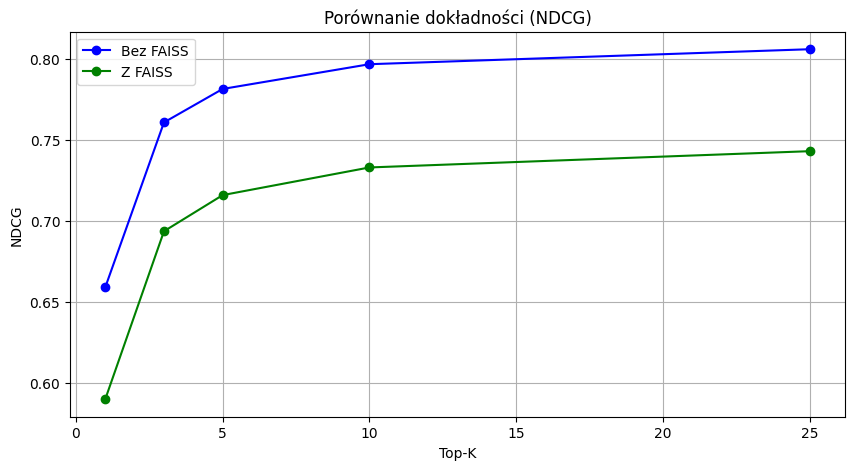

In [32]:
import matplotlib.pyplot as plt

# Wykres 1: Dokładność (NDCG)
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, ndcg, marker='o', label='Bez FAISS', color='blue')
plt.plot(topk_arr, ndcg_with_faiss, marker='o', label='Z FAISS', color='green')
plt.title('Porównanie dokładności (NDCG)')
plt.xlabel('Top-K')
plt.ylabel('NDCG')
plt.grid(True)
plt.legend()
plt.show()

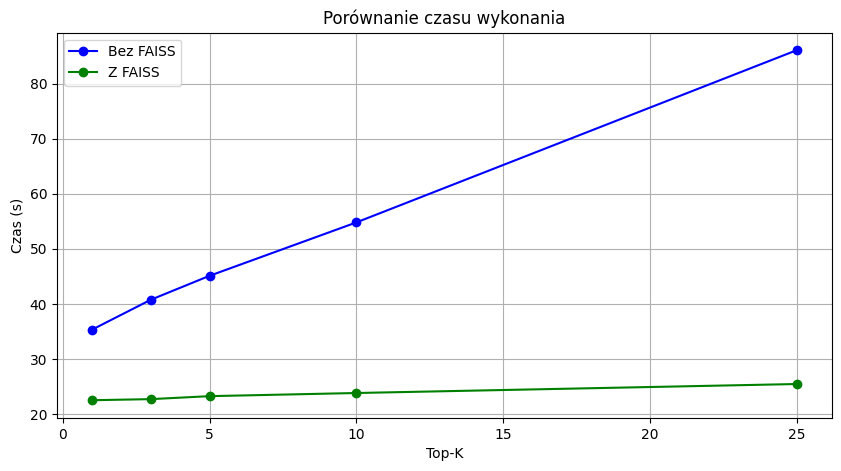

In [33]:
# Wykres 2: Czas wykonania
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, t, marker='o', label='Bez FAISS', color='blue')
plt.plot(topk_arr, t_with_faiss, marker='o', label='Z FAISS', color='green')
plt.title('Porównanie czasu wykonania')
plt.xlabel('Top-K')
plt.ylabel('Czas (s)')
plt.grid(True)
plt.legend()
plt.show()